初期値： [2500, 950, 20, 500, 1250, 100, 1] ,    mean： 108.67900701217297
Result： [2501.5  944.5   25.9  628.8 1215.8  103.9    5.5] ,   mean： 42.68212769705477


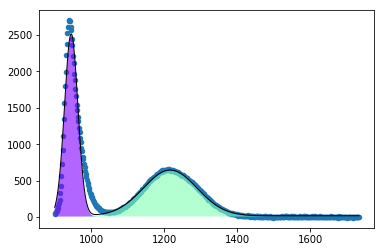

In [1]:
%matplotlib inline
from fitting_module import Fit, Plot

if __name__ == "__main__":
    # Read CSV data
    filename = 'V200309B'

    #初期パラメーターのリスト[amp,ctr,wid]
    guess = [[2500, 950, 20]]
    #guess.append([1100, 980, 30])
    guess.append([500, 1250, 100])
    background = 1  #バックグラウンドの初期値

    res = Fit(filename, guess, background)  #フィッティング実行
    res.to_csv(1)                           #プロットをcsvに保存
    res.save_parameter(1)                   #フィッティングパラメーターをcsvに保存

    fig = Plot(res)                         #フィッティングのプロット
    fig.save(1)                             #図の保存
